See: https://gp12.datalab.noirlab.edu/user/adrian/lab/tree/notebooks/Field-of-Streams-DELVE-DR2.ipynb

In [17]:
import pathlib

import astropy.coordinates as coord
import astropy.table as at
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

from dustmaps.planck import PlanckGNILCQuery

In [2]:
tables = []
for filename in pathlib.Path('.').glob('*.csv'):
    tables.append(at.Table.read(filename))

In [3]:
joined = at.vstack(tables)

In [18]:
c = coord.SkyCoord(
    ra=joined['ra']*u.deg,
    dec=joined['dec']*u.deg
)

In [19]:
ebv = PlanckGNILCQuery().query(c)

In [20]:
# Schlafly:
Acoeffs = {
    'g': 3.237,
    'r': 2.176,
    'i': 1.595
}

In [22]:
joined['g0'] = joined['mag_psf_g'] - Acoeffs['g'] * ebv
joined['r0'] = joined['mag_psf_r'] - Acoeffs['r'] * ebv
joined['i0'] = joined['mag_psf_i'] - Acoeffs['i'] * ebv

In [4]:
joined.write('delve_dr2_stars.fits', overwrite=True)

In [25]:
joined_f32 = joined['ra', 'dec', 'g0', 'r0', 'i0']
for col in joined_f32.colnames:
    joined_f32[col] = joined_f32[col].astype(np.float32)

joined_f32.write('delve_dr2_stars_lite.fits', overwrite=True)

In [5]:
H, xe, ye = np.histogram2d(
    joined['ra'], joined['dec'],
    bins=(np.arange(0, 360+1e-3, 1),
          np.arange(-90., 90+1e-3, 1.))
)

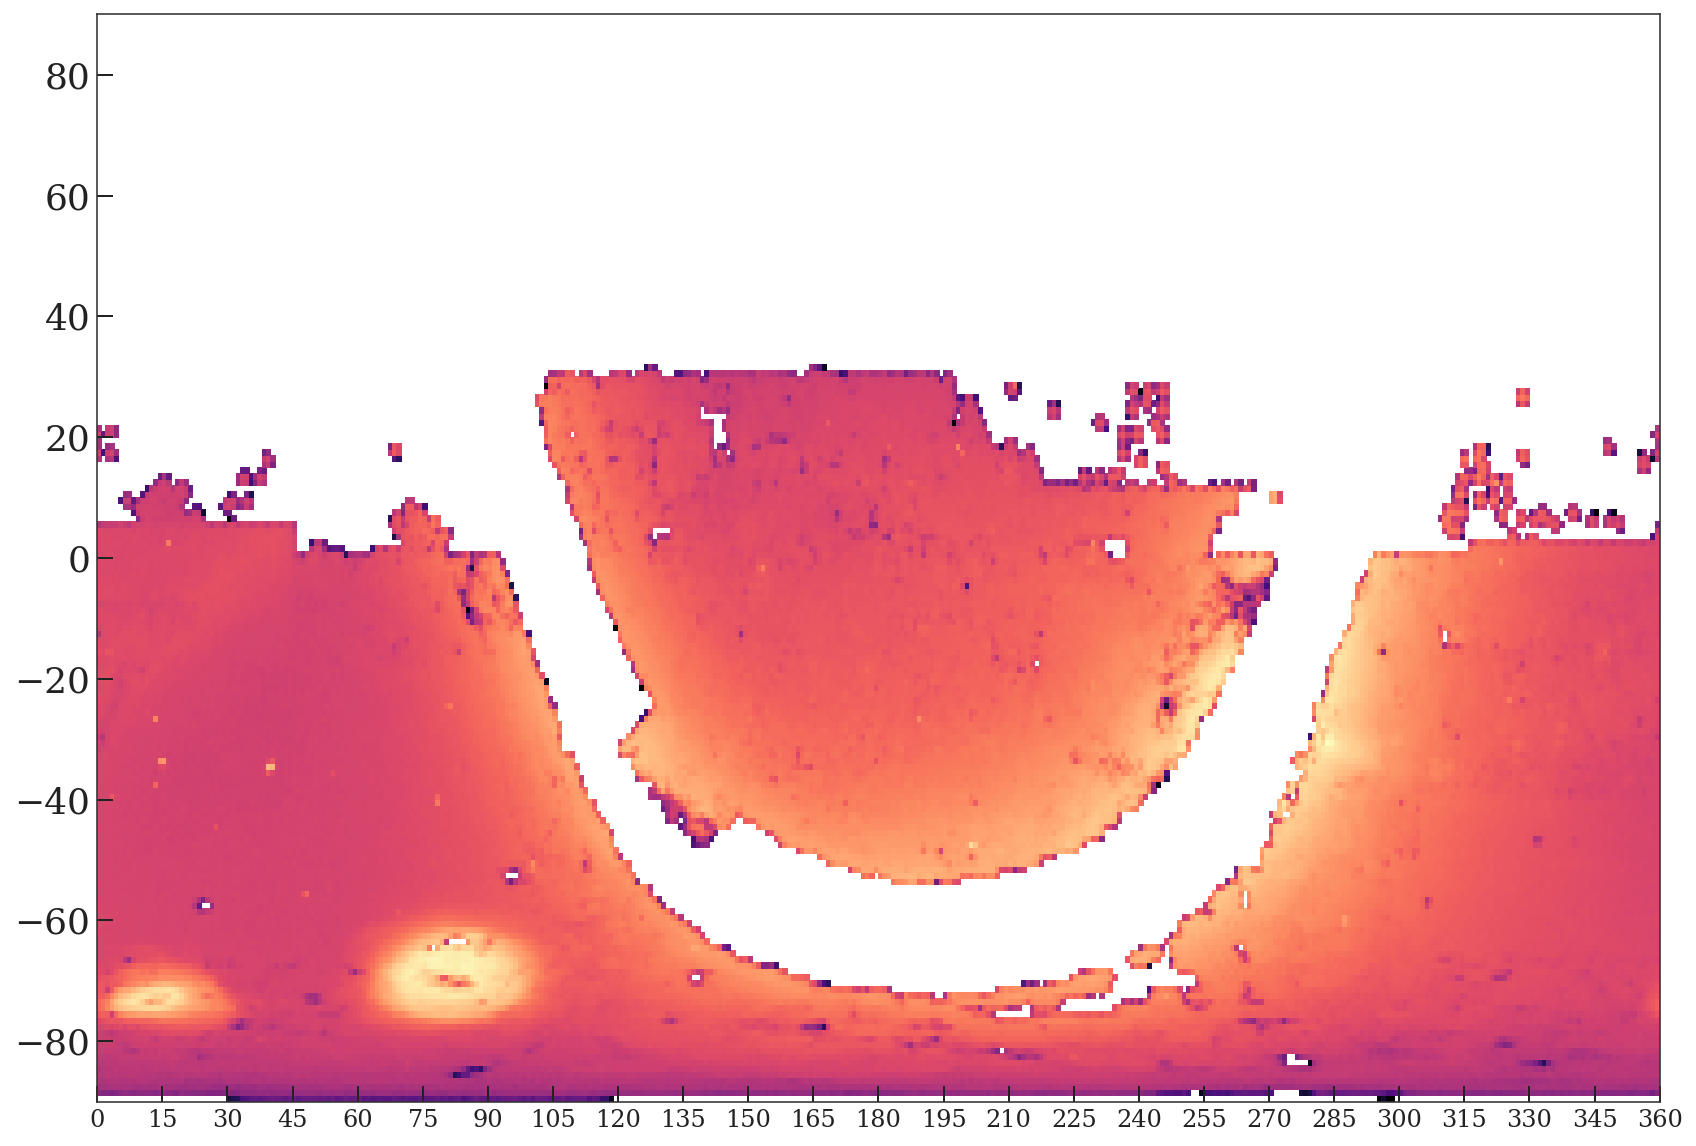

In [6]:
fig, ax = plt.subplots(figsize=(14, 10))
ax.pcolormesh(xe, ye, H.T, norm=mpl.colors.LogNorm())
ax.xaxis.set_ticks(np.arange(0, 360+1, 15));
ax.xaxis.set_ticklabels(np.arange(0, 360+1, 15), fontsize=12);

In [7]:
import healpy as hp

In [8]:
nside = 64
npix = hp.nside2npix(nside)

In [9]:
indices = hp.ang2pix(nside, joined['ra'], joined['dec'], lonlat=True)

In [10]:
hpxmap = np.zeros(npix, dtype=np.float64)
np.add.at(hpxmap, indices, np.ones_like(indices))

/tmp/ipykernel_859160/1828620610.py:1: RuntimeWarning: divide by zero encountered in log
  hp.mollview(np.log(hpxmap))


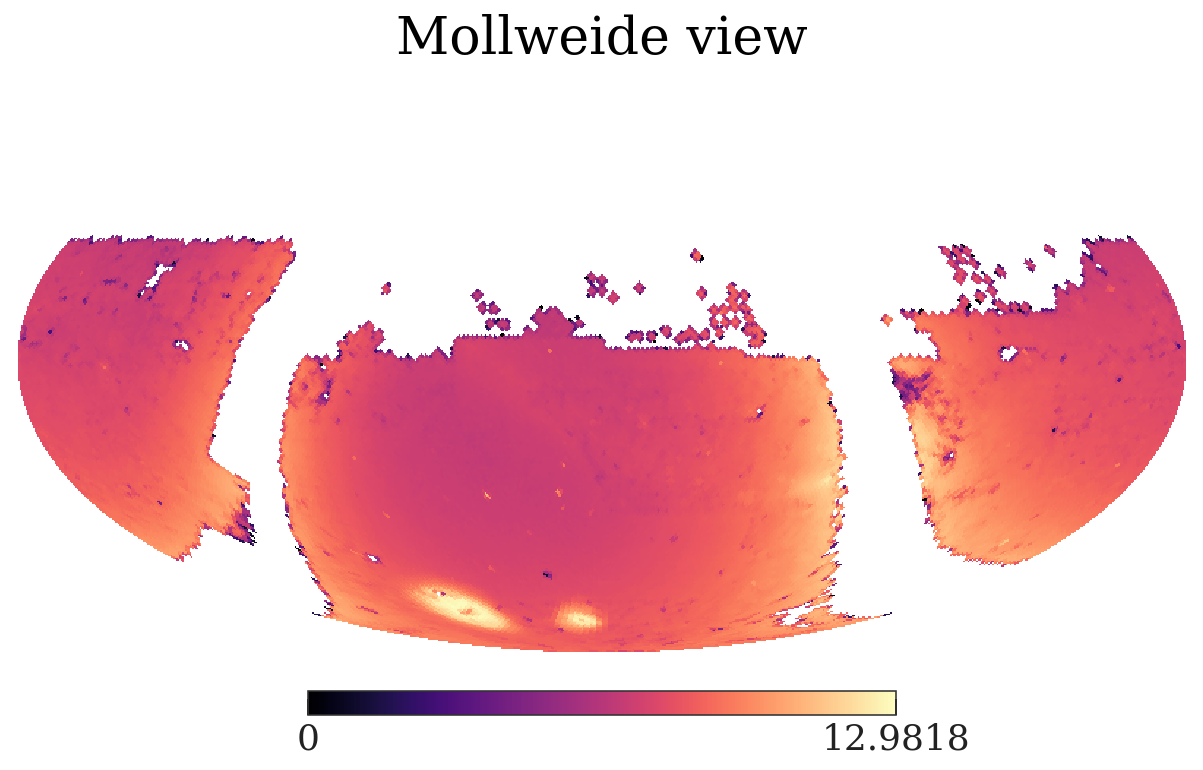

In [11]:
hp.mollview(np.log(hpxmap))

In [15]:
H_cmd, xe_cmd, ye_cmd = np.histogram2d(
    joined['mag_psf_g'] - joined['mag_psf_i'], 
    joined['mag_psf_r'],
    bins=(np.linspace(-1, 1.5, 128),
          np.linspace(12, 24, 128))
)

(24.0, 14.0)

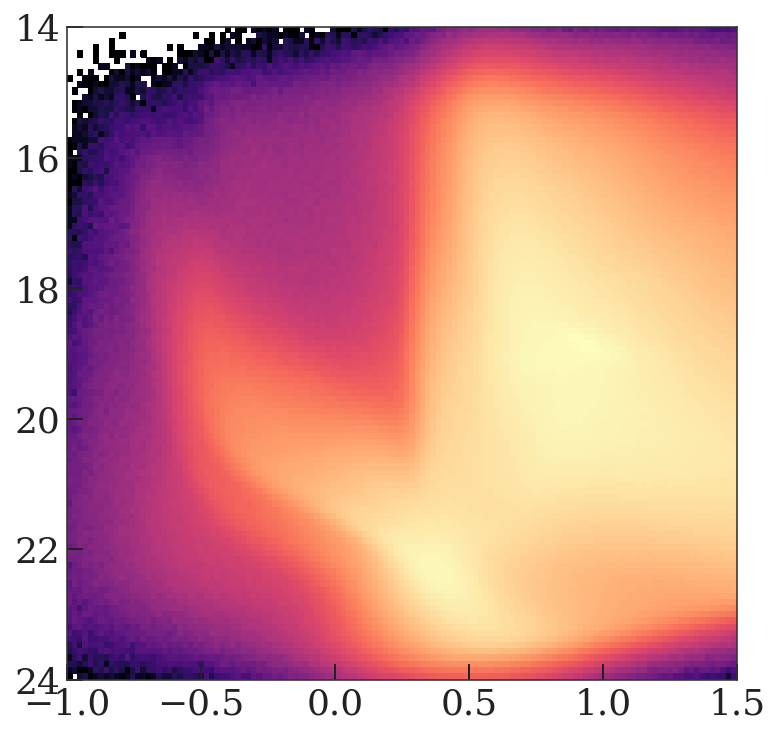

In [16]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.pcolormesh(xe_cmd, ye_cmd, H_cmd.T, norm=mpl.colors.LogNorm())
ax.set_ylim(24, 14)